In [240]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


In [241]:
df = pd.read_excel("pm10s_classes500m.xlsx")
print(df.head())

   Unnamed: 0       Data  Estacao id               Estacao       pm10  \
0           0 2018-06-20        1054          Anta-Espinho  13.681818   
1           1 2018-06-20        3093                 Arcos  36.491667   
2           2 2018-06-20        2017                Aveiro  27.125000   
3           3 2018-06-20        3075  Avenida da Liberdade  48.416667   
4           4 2018-06-20        1053               Avintes  27.200000   

   pm10_weighted Uso_solo_simplificado_500m  Urbanizado  Transporte  
0      20.646031                     Outros           0           0  
1      32.937641                 Urbanizado           1           0  
2      18.858698                 Urbanizado           1           0  
3      32.890849                 Transporte           0           1  
4      21.891247                     Outros           0           0  


In [242]:
#Covariancias
df["urban_pm10w"] = df["Urbanizado"] * df["pm10_weighted"]
df["transp_pm10w"] = df["Transporte"] * df["pm10_weighted"]
print(df.head())

   Unnamed: 0       Data  Estacao id               Estacao       pm10  \
0           0 2018-06-20        1054          Anta-Espinho  13.681818   
1           1 2018-06-20        3093                 Arcos  36.491667   
2           2 2018-06-20        2017                Aveiro  27.125000   
3           3 2018-06-20        3075  Avenida da Liberdade  48.416667   
4           4 2018-06-20        1053               Avintes  27.200000   

   pm10_weighted Uso_solo_simplificado_500m  Urbanizado  Transporte  \
0      20.646031                     Outros           0           0   
1      32.937641                 Urbanizado           1           0   
2      18.858698                 Urbanizado           1           0   
3      32.890849                 Transporte           0           1   
4      21.891247                     Outros           0           0   

   urban_pm10w  transp_pm10w  
0     0.000000      0.000000  
1    32.937641      0.000000  
2    18.858698      0.000000  
3     0.00

In [243]:


X = df[[
    "pm10_weighted",
    "Urbanizado",
    "Transporte",
    "urban_pm10w",
    "transp_pm10w"
]]

y = df["pm10"]


# Convert to NumPy arrays for cross-validation
X_np = X.values
y_np = y.values


In [244]:
def full_lasso_diagnostics(X, y, alphas, cv_strategy, feature_names=None, label="model", plot=True):
    results = []
    y = np.asarray(y)
    X = np.asarray(X)

    for alpha in alphas:
        model = make_pipeline(
            ColumnTransformer([
                ('scale', StandardScaler(), [0, -2, -1]),  # scale first and last 2 columns
                ('passthrough', 'passthrough', [i for i in range(1, X.shape[1] - 2)])  # leave others
            ]),
            Lasso(alpha=alpha, max_iter=10000)
        )
        y_true_all, y_pred_all = [], []

        for train_idx, test_idx in cv_strategy.split(X):
            model.fit(X[train_idx], y[train_idx])
            y_pred = model.predict(X[test_idx])
            y_true_all.extend(y[test_idx])
            y_pred_all.extend(y_pred)

        r2 = r2_score(y_true_all, y_pred_all)
        rmse = np.sqrt(mean_squared_error(y_true_all, y_pred_all))
        mae = mean_absolute_error(y_true_all, y_pred_all)
        nonzero_count = np.sum(model.named_steps["lasso"].coef_ != 0)

        results.append({
            label: "with_cov" if X.shape[1] > 3 else "no_cov",
            "alpha": alpha,
            "r2": r2,
            "rmse": rmse,
            "mae": mae,
            "nonzero_features": nonzero_count
        })

    results_df = pd.DataFrame(results)
    best_row = results_df.sort_values("r2", ascending=False).iloc[0]
    best_alpha = best_row["alpha"]

    # Fit best model on all data
    final_model = make_pipeline(ColumnTransformer([
                ('scale', StandardScaler(), [0, -2, -1]),  # scale first and last 2 columns
                ('passthrough', 'passthrough', [i for i in range(1, X.shape[1] - 2)])  # leave others
            ]),
            Lasso(alpha=best_alpha, max_iter=10000)
        )
    final_model.fit(X, y)
    y_pred_full = final_model.predict(X)
    residuals = y - y_pred_full
    coefs = final_model.named_steps["lasso"].coef_

    if feature_names is None:
        feature_names = [f"x{i}" for i in range(X.shape[1])]

    if plot:
        # 1. R² and RMSE vs Alpha
        fig, ax = plt.subplots(1, 2, figsize=(12, 5))
        sns.lineplot(data=results_df, x="alpha", y="r2", marker="o", ax=ax[0])
        ax[0].set_xscale("log")
        ax[0].set_title("R² vs Alpha")
        ax[0].grid(True)

        sns.lineplot(data=results_df, x="alpha", y="rmse", marker="o", ax=ax[1])
        ax[1].set_xscale("log")
        ax[1].set_title("RMSE vs Alpha")
        ax[1].grid(True)
        plt.tight_layout()
        plt.show()

        # 2. Residuals vs Predicted
        plt.figure(figsize=(6, 5))
        sns.scatterplot(x=y_pred_full, y=residuals)
        plt.axhline(0, linestyle="--", color="gray")
        plt.title("Residuals vs Predicted")
        plt.xlabel("Predicted PM10")
        plt.ylabel("Residuals")
        plt.grid(True)
        plt.show()

        # 3. Histogram of Residuals
        plt.figure(figsize=(6, 4))
        sns.histplot(residuals, kde=True, bins=20)
        plt.title("Histogram of Residuals")
        plt.xlabel("Residual")
        plt.grid(True)
        plt.show()

        # 4. Actual vs Predicted
        plt.figure(figsize=(6, 6))
        sns.scatterplot(x=y, y=y_pred_full)
        plt.plot([y.min(), y.max()], [y.min(), y.max()], '--k')
        plt.xlabel("Actual PM10")
        plt.ylabel("Predicted PM10")
        plt.title("Actual vs Predicted")
        plt.grid(True)
        plt.show()

        # 5. Coefficient Bar Chart
        plt.figure(figsize=(8, 4))
        sns.barplot(x=feature_names, y=coefs)
        plt.xticks(rotation=45)
        plt.title(f"Feature Coefficients (α={best_alpha:.2f})")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # 6. Coefficient Paths
        coef_matrix = []
        path_alphas = np.arange(0.5, 10.5, 0.5)
        for a in path_alphas:
            m = make_pipeline(ColumnTransformer([
                ('scale', StandardScaler(), [0, -2, -1]),  # scale first and last 2 columns
                ('passthrough', 'passthrough', [i for i in range(1, X.shape[1] - 2)])  # leave others
            ]),
            Lasso(alpha=a, max_iter=10000)
        )
            m.fit(X, y)
            coef_matrix.append(m.named_steps["lasso"].coef_)
        coef_matrix = np.array(coef_matrix)

        plt.figure(figsize=(10, 6))
        for i in range(X.shape[1]):
            plt.plot(path_alphas, coef_matrix[:, i], label=feature_names[i])
        plt.xscale("log")
        plt.xlabel("Alpha (λ)")
        plt.ylabel("Coefficient")
        plt.title("Lasso Coefficient Paths")
        plt.axhline(0, linestyle="--", color="gray")
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.grid(True)
        plt.show()

        # 7. Nonzero Feature Count vs Alpha
        plt.figure(figsize=(7, 4))
        sns.lineplot(data=results_df, x="alpha", y="nonzero_features", marker="o")
        plt.xscale("log")
        plt.title("Number of Nonzero Features vs Alpha")
        plt.grid(True)
        plt.show()

    print("Lasso regression (APLICADA AOS DADOS INTEIROS):")
    print(f"\nBest Alpha: {best_alpha:.2f}")
    print(f"R²:   {r2_score(y, y_pred_full):.3f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y, y_pred_full)):.3f}")
    print(f"MAE:  {mean_absolute_error(y, y_pred_full):.3f}")

    return {
        "best_model": final_model,
        "best_alpha": best_alpha,
        "results_df": results_df,
        "residuals": residuals,
        "coefficients": coefs
    }


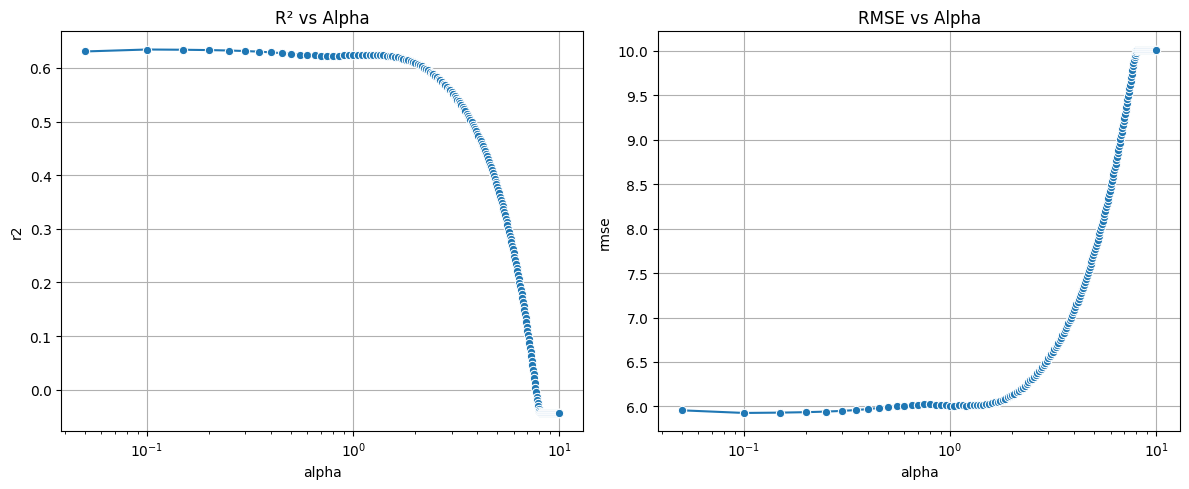

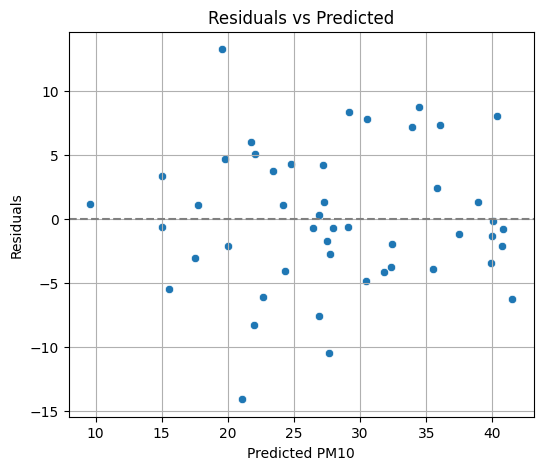

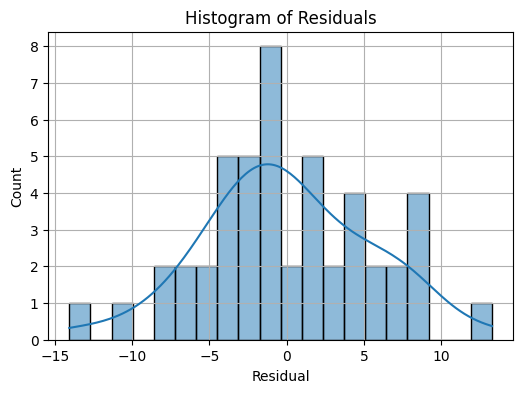

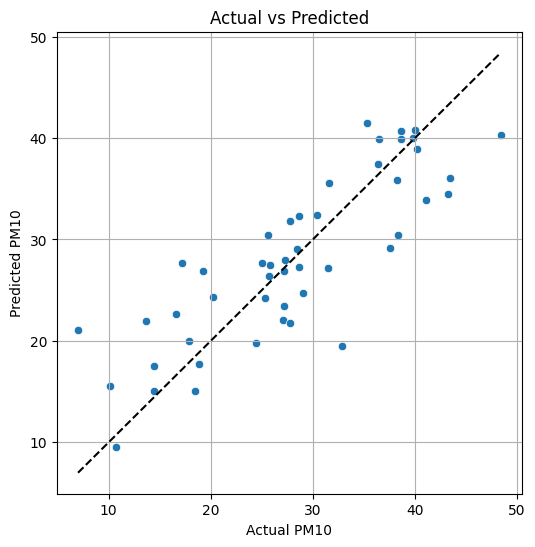

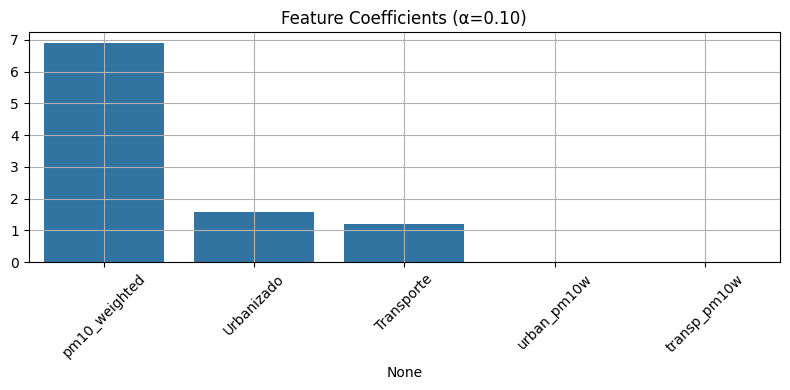

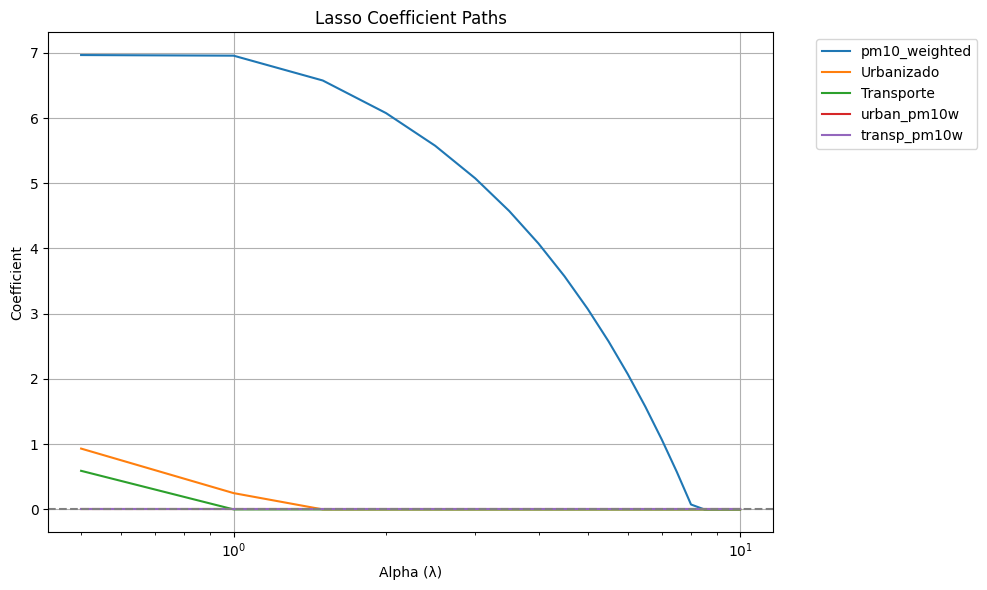

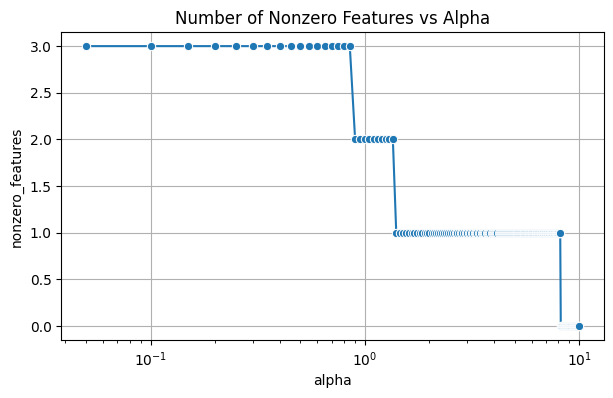

Lasso regression (APLICADA AOS DADOS INTEIROS):

Best Alpha: 0.10
R²:   0.698
RMSE: 5.385
MAE:  4.232
Cross-validated (TEST-ONLY) metrics for best alpha:
Alpha: 0.1
R²:    0.634
RMSE:  5.927
MAE:   4.646


In [245]:
alphas = np.arange(0.05, 10.05, 0.05)
cv = LeaveOneOut()
#cv = KFold(n_splits=5, shuffle=True, random_state=42)

result = full_lasso_diagnostics(
    X=X.values,
    y=y.values,
    alphas=alphas,
    cv_strategy=cv,
    feature_names=X.columns,
    plot=True
)

results_df = result["results_df"]
best_alpha_row = results_df.sort_values("r2", ascending=False).iloc[0]
print("Cross-validated (TEST-ONLY) metrics for best alpha:")
print(f"Alpha: {best_alpha_row['alpha']}")
print(f"R²:    {best_alpha_row['r2']:.3f}")
print(f"RMSE:  {best_alpha_row['rmse']:.3f}")
print(f"MAE:   {best_alpha_row['mae']:.3f}")

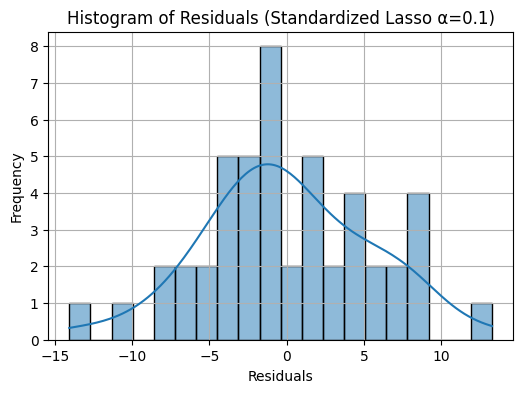

True

In [246]:
preprocessor = ColumnTransformer([
                ('scale', StandardScaler(), [0, -2, -1]),  # scale first and last 2 columns
                ('passthrough', 'passthrough', [i for i in range(1, X.shape[1] - 2)])  # leave others
            ])
model = make_pipeline(preprocessor, Lasso(alpha=0.1, max_iter=10000))
model.fit(X, y)
y_pred = model.predict(X)
residuals_1 = y - y_pred



plt.figure(figsize=(6, 4))
sns.histplot(residuals_1, kde=True, bins=20)
plt.title("Histogram of Residuals (Standardized Lasso α=0.1)")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

np.allclose(residuals_1, residuals)


In [247]:
# Extract Lasso from the pipeline
lasso = model.named_steps['lasso']
coefs_scaled = lasso.coef_
intercept_scaled = lasso.intercept_

# Print scaled equation
feature_names = X.columns
terms = [f"{coef:.3f}*{name}" for coef, name in zip(coefs_scaled, feature_names)]
equation_scaled = " + ".join(terms) + f" + {intercept_scaled:.3f}"
print("Scaled equation (equação ainda normalizada):\n", equation_scaled)


Scaled equation (equação ainda normalizada):
 6.890*pm10_weighted + 1.564*Urbanizado + 1.212*Transporte + 0.000*urban_pm10w + 0.000*transp_pm10w + 28.171


In [248]:
X = df[[
    "pm10_weighted",
    "Urbanizado",
    "Transporte",
    "urban_pm10w",
    "transp_pm10w"
]]

y = df["pm10"]


In [249]:
# Assume: result["best_model"] is your fitted Pipeline
pipe: Pipeline = result["best_model"]
ct: ColumnTransformer = pipe.named_steps["columntransformer"]
scaler: StandardScaler = ct.named_transformers_["scale"]
lasso = pipe.named_steps["lasso"]

# Step 1: Get indices of scaled columns
scaled_indices = ct.transformers_[0][2]  # e.g., [0, 3, 4]
passthrough_indices = ct.transformers_[1][2]  # e.g., [1, 2]

# Step 2: Reconstruct full X column order after transformation
# Order in transformed X is: scaled columns first, then passthrough
all_indices = list(scaled_indices) + list(passthrough_indices)

# Step 3: Reorder coefficients to match original feature order
# First unscale coefficients
coefs_scaled = lasso.coef_
coefs_unscaled = np.zeros_like(coefs_scaled)

# Apply inverse scaling only to scaled columns
for i, idx in enumerate(scaled_indices):
    coefs_unscaled[idx] = coefs_scaled[i] / scaler.scale_[i]

# For passthrough cols, copy directly
for j, idx in enumerate(passthrough_indices):
    coefs_unscaled[idx] = coefs_scaled[len(scaled_indices) + j]

# Adjust intercept
intercept_unscaled = lasso.intercept_
for i, idx in enumerate(scaled_indices):
    intercept_unscaled -= coefs_scaled[i] * scaler.mean_[i] / scaler.scale_[i]

# Build equation
terms_unscaled = [f"{coef:.3f}*{name}" for coef, name in zip(coefs_unscaled, feature_names)]
equation_unscaled = " + ".join(terms_unscaled) + f" + {intercept_unscaled:.3f}"
print("Unscaled equation (equação 'desnormalizada'):\n", equation_unscaled)


Unscaled equation (equação 'desnormalizada'):
 1.155*pm10_weighted + 0.000*Urbanizado + 0.000*Transporte + 0.114*urban_pm10w + 0.128*transp_pm10w + -1.894


In [250]:
y_pred_manual = X.to_numpy() @ coefs_unscaled + intercept_unscaled
residuals_manual = y.to_numpy() - y_pred_manual

print(np.allclose(residuals_manual, result["residuals"]))
print(np.max(np.abs(residuals_manual - result["residuals"])))


True
7.105427357601002e-15


In [251]:
residuals_df = pd.DataFrame({
    "manual_residuals": residuals_manual,
    "pipeline_residuals": result["residuals"],
    "difference": residuals_manual - result["residuals"],
    "pm10": y,
    "ypred": y_pred_manual,
    "pm10_weighted": X["pm10_weighted"],
    "difference_2": y- X["pm10_weighted"],
})

print(residuals_df.head())

print(residuals_df["manual_residuals"].abs().sum())
print(residuals_df["difference_2"].abs().sum())


   manual_residuals  pipeline_residuals  difference       pm10      ypred  \
0         -8.272845           -8.272845         0.0  13.681818  21.954663   
1         -3.412755           -3.412755         0.0  36.491667  39.904422   
2          5.087199            5.087199         0.0  27.125000  22.037801   
3          8.103945            8.103945         0.0  48.416667  40.312721   
4          3.806932            3.806932         0.0  27.200000  23.393068   

   pm10_weighted  difference_2  
0      20.646031     -6.964213  
1      32.937641      3.554025  
2      18.858698      8.266302  
3      32.890849     15.525817  
4      21.891247      5.308753  
203.13831506612956
273.9506450313389


In [ ]:
df["lasso_pm10"] = y_pred_manual
df["residuals"] = residuals_manual



In [253]:
df.to_excel("dataframe_com_residuos.xlsx")